## ME6151 Assignment 3 
### by Anushka Venkatesh ME21B026


In [15]:
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# Constants for problem 2
L=3 # length of square domain
rho= 2 # density
Gamma = 3 # diffusion constant

# Velocity functions
u = lambda x: x**2 + 1
v = lambda y: y**2 + 1

# Source term
source_func = lambda x, y: 2 * (x + y)

#### FVM Solver for a square mesh with CDS and QUICK schemes for convection

In [24]:
def gauss_seidel(N, scheme='CDS', max_iter=10000, tol=1e-6):

    #generate the grid
    dx = L / N
    dy = L / N
    x = np.linspace(0, L, N+2)
    y = np.linspace(0, L, N+2)
    X, Y = np.meshgrid(x, y, indexing='ij')
    phi = np.zeros((N+2, N+2))

    # Boundary conditions
    phi[:, 0] = 1    # Bottom boundary (phi = 1)
    phi[0, :] = 0    # Left boundary (phi = 0)

    for it in range(max_iter):
        phi_old = phi.copy()
        for i in range(1, N+1):
            for j in range(1, N+1):
                # Velocities
                u_e = u(x[i+1])
                u_w = u(x[i-1])
                v_n = v(y[j+1])
                v_s = v(y[j-1])

                # Diffusive terms
                De = Gamma * dy / dx
                Dw = Gamma * dy / dx
                Dn = Gamma * dx / dy
                Ds = Gamma * dx / dy

                # Convective fluxes
                Fe = rho * u_e * dy
                Fw = rho * u_w * dy
                Fn = rho * v_n * dx
                Fs = rho * v_s * dx

                if scheme == 'CDS':
                    # Face values
                    phi_e = 0.5 * (phi[i+1, j] + phi[i, j])
                    phi_w = 0.5 * (phi[i-1, j] + phi[i, j])
                    phi_n = 0.5 * (phi[i, j+1] + phi[i, j])
                    phi_s = 0.5 * (phi[i, j-1] + phi[i, j])
                    # Co-efficients
                    aE = De - Fe/2
                    aW = Dw + Fw/2
                    aN = Dn - Fn/2
                    aS = Ds + Fs/2
                    aP = De+Dw+Dn+Ds+Fe/2-Fw/2+Fn/2-Fs/2
                    #Source Term
                    S = source_func(x[i], y[j]) * dx * dy

                elif scheme == 'QUICK':
                    # setting up according to upwind scheme
                    phi_e = phi[i, j]  
                    phi_w = phi[i-1, j] if 0 < i else 0
                    phi_n = phi[i, j] 
                    phi_s = phi[i, j-1]  if 0 < j else 1
                    # coefficients
                    aE= De
                    aW= Fw +Dw
                    aN= Dn
                    aS= Ds+ Fs
                    aP= Fe + Fn + De+Dw+Dn+Ds
                    # Extra source term to take care of higher order QUICK scheme
                    del_phi_E = Fe*(1/8)*((-2*phi[i,j])+ (3* phi[i+1,j])- phi[i-1,j]) if 0<i<N+1 else 0
                    del_phi_W=  Fw*(1/8)*((-2*phi[i-1,j])+ (3* phi[i,j])- phi[i-2,j]) if 1<i<N+1 else 0
                    del_phi_N = Fn*(1/8)*((-2*phi[i,j])+ (3* phi[i,j+1])- phi[i,j-1]) if 0<j<N+1 else 0
                    del_phi_S=  Fs*(1/8)*((-2*phi[i,j-1])+ (3* phi[i,j])- phi[i,j-2]) if 1<j<N+1 else 0
                    del_phi= -del_phi_E + del_phi_W - del_phi_N + del_phi_S
                    # Source Term
                    S = (source_func(x[i], y[j]) * dx * dy) + del_phi
                    
                else:
                    raise ValueError("Unknown scheme")
                
                phi[i, j] = (aE * phi[i+1, j] + aW * phi[i-1, j] +
                             aN * phi[i, j+1] + aS * phi[i, j-1] + S) / aP
            
                
        """      
        #Update the outflow rows each iteration (pure upwind and no diffusion)
        # Topmost row
        for i in range(N-2):
            j=N-1
            phi_e = phi[i, j]  
            phi_w = phi[i-1, j]
            phi_n = phi[i, j] 
            phi_s = phi[i, j-1]
            
            aW= Fw
            aS= Fs
            aP= Fe + Fn 
            S = source_func(x[i], y[j])
            phi[i, j] = ( aW * phi[i-1, j] + aS * phi[i, j-1] + S) / aP

        # Right-most column
        for j in range(N-2):
            i=N-1
            phi_e = phi[i, j]  
            phi_w = phi[i-1, j]
            phi_n = phi[i, j] 
            phi_s = phi[i, j-1]
            
            aW= Fw
            aS= Fs
            aP= Fe + Fn 
            S = source_func(x[i], y[j])
            phi[i, j] = ( aW * phi[i-1, j] + aS * phi[i, j-1] + S) / aP
            """
        error = np.linalg.norm(phi - phi_old) / np.linalg.norm(phi_old + 1e-12)
        if error < tol:
            break
    return x, y, phi

In [25]:
# Run for 20x20 and 50x50 meshes
results = {}
for N in [20, 50]:
    x, y, phi_cds = gauss_seidel(N, 'CDS')
    _, _, phi_quick = gauss_seidel(N, 'QUICK')
    results[N] = (phi_cds, phi_quick, x, y)

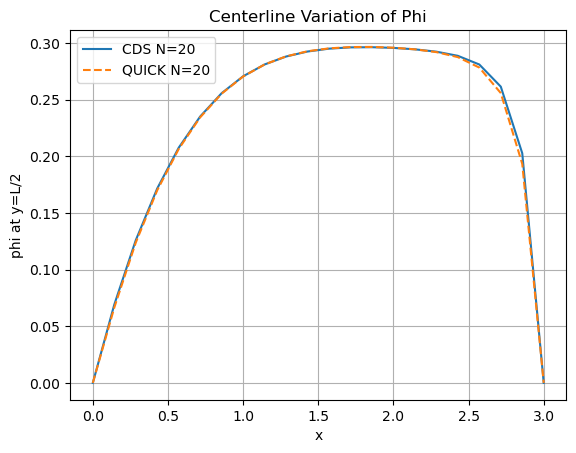

In [26]:
# Plot centerline values for 20 x 20
N=20
phi_cds, phi_quick, x, y = results[N]
plt.plot(x, phi_cds[:, N//2], label=f'CDS N={N}')
plt.plot(x, phi_quick[:, N//2], '--', label=f'QUICK N={N}')

plt.xlabel('x')
plt.ylabel('phi at y=L/2')
plt.title('Centerline Variation of Phi')
plt.legend()
plt.grid(True)
plt.show()

In [27]:
results[20]


(array([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [1.        , 0.49144998, 0.28538354, 0.18866403, 0.13766448,
         0.10859186, 0.09127943, 0.08080977, 0.07454783, 0.07096784,
         0.06913609, 0.06845858, 0.06854665, 0.06913953, 0.07005554,
         0.07115524, 0.07229872, 0.07325654, 0.07343654, 0.07087092,
         0.05790704, 0.        ],
        [1.        , 0.68248664, 0.46999635, 0.338099  , 0.25639798,
         0.20510494, 0.17253677, 0.15179625, 0.13870127, 0.1306367 ,
         0.12592244, 0.12345542, 0.12249835, 0.12254913, 0.12325412,
         0.12433987, 0.125532  , 0.12638669, 0.12578646, 0.12014621,
         0.09627754, 0.        ],
        [1.        , 0.76611456, 0.57795278, 0.44162281, 0.34714534,
 

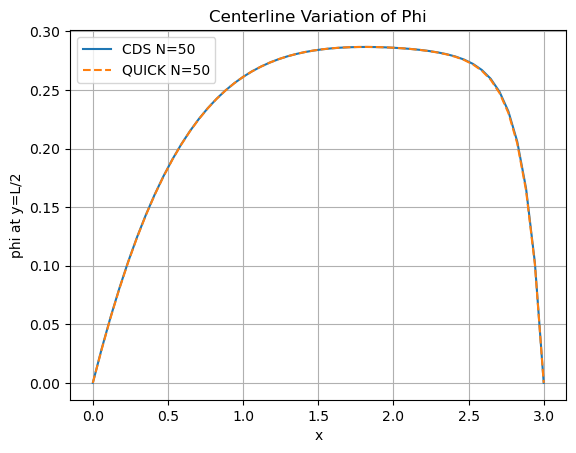

In [28]:
# Plot centerline values for 20 x 20
N=50
phi_cds, phi_quick, x, y = results[N]
plt.plot(x, phi_cds[:, N//2], label=f'CDS N={N}')
plt.plot(x, phi_quick[:, N//2], '--', label=f'QUICK N={N}')

plt.xlabel('x')
plt.ylabel('phi at y=L/2')
plt.title('Centerline Variation of Phi')
plt.legend()
plt.grid(True)
plt.show()